# inspect the processed data. Feature map and segmentation

## data load in

In [16]:
# data loading 
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
import os
import pandas as pd
import random

In [2]:
# visualization for two images

def subShow(IMG1, IMG2):
    plt.figure()
    plt.subplot(1,2,1)
    plt.imshow(IMG1, cmap='gray')
    plt.subplot(1,2,2)
    plt.imshow(IMG2, cmap='gray')
    plt.show()

In [3]:
# 15 stacks of the images

PATH = '/bigdata/casus/MLID/RuiLi/Data/LM/zebrafish_partial_15/'

Mask = np.load(PATH + 'biMasks15.npy')
IMG = np.load(PATH + 'rawGray15.npy')

Mask = Mask.reshape(-1, 1040, 1392)  # flatten into images 
IMG = IMG.reshape(-1, 1040, 1392)
print('before:', Mask.shape)

before: (300, 1040, 1392)


slice Num: 216


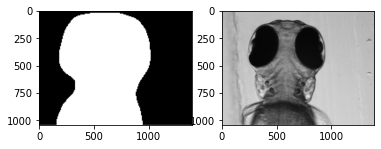

In [4]:
# sanity check

n_slice = random. randint(0, Mask.shape[0])
print('slice Num:', n_slice)
subShow(Mask[n_slice,...], IMG[n_slice,...])

## crop the images

In [5]:
# [1040, 1392] -> [1040, 1040]

cropMask = Mask[...,176:(176+Mask.shape[1])]  # crop for later scaling
cropIMG = IMG[...,176:(176+IMG.shape[1])]

print('small Mask info: ', cropMask.shape, cropMask.dtype)
print('small Image info: ', cropIMG.shape, cropIMG.dtype)

small Mask info:  (300, 1040, 1040) uint8
small Image info:  (300, 1040, 1040) uint8


slice Num: 118


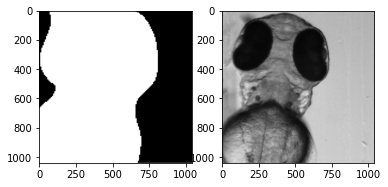

In [6]:
# sanity check

n_slice = random. randint(0, cropMask.shape[0])
print('slice Num:', n_slice)
subShow(cropMask[n_slice,...], cropIMG[n_slice,...])

In [7]:
Mask = cropMask
IMG = cropIMG

## Resize the image

In [8]:
# resize the images

from skimage.transform import resize

SIZE = [256, 256]
totalIMG = Mask.shape[0]
# numIMG = 250
numIMG = totalIMG

smallIMG = resize(IMG[:numIMG,...], (numIMG,SIZE[0],SIZE[1]), anti_aliasing=True)
smallIMG = np.interp(smallIMG, (smallIMG.min(), smallIMG.max()), (0, 1))  # rescale the img

smallMask = resize(Mask[:numIMG,...].astype(bool), (numIMG,SIZE[0],SIZE[1]), anti_aliasing=False)
smallMask = smallMask.astype(int)
print('after resize:', smallIMG.shape, IMG.shape)

after resize: (300, 256, 256) (300, 1040, 1040)


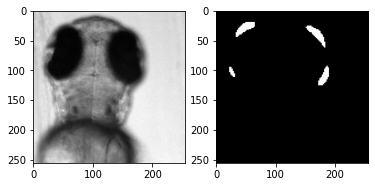

img: (300, 256, 256) float64
mask: (300, 256, 256) int64
img range: 1.0 0.0
mask range: 1 0


In [9]:
# sanity check for the resized data

subShow(smallIMG[0,...], smallMask[0,...])

print('img:',smallIMG.shape, smallIMG.dtype)
print('mask:',smallMask.shape, smallMask.dtype)

print('img range:', np.max(smallIMG), np.min(smallIMG))  # continuous/ np.unique(smallIMG)
print('mask range:', np.max(smallMask), np.min(smallMask))  # binay. np.unique(smallMask)

## patchify the image

In [22]:
# patchify the images

from patchify import patchify, unpatchify

def rawPatch(imageStack,patchPara):
    all_img_patches = []

    for img in range(imageStack.shape[0]):
        large_image = imageStack[img]

        patches_img = patchify(large_image, (patchPara['x'],patchPara['y']), step=patchPara['step'])  # no overlap

        for i in range(patches_img.shape[0]):
            for j in range(patches_img.shape[1]):

                single_patch_img = patches_img[i,j,:,:]
                # transform the image if the type is not correct
                if single_patch_img.dtype == 'uint8':
                    single_patch_img = (single_patch_img.astype('float32')) / 255.  # remember to standarize into 0-1
                    
                all_img_patches.append(single_patch_img)
    
    return all_img_patches, patches_img.shape

In [35]:
# preporcessing the data into patches
# X-img, Y-mask

# patchify the data.
patchPara = {'x': 256, 'y': 256, 'step':256}

X_patches, _ =  rawPatch(smallIMG, patchPara); X_patches = np.stack((X_patches,)*3, axis=-1)  # here padd into 3 channels for transfer (vgg takes rgb)
Y_masks, _ = rawPatch(smallMask, patchPara); Y_masks = np.expand_dims(Y_masks, -1)

NUM = random.randint(0, X_patches.shape[0])
print('target num:', NUM)
print('patches shape:',X_patches.shape, np.min(X_patches[NUM,...]), np.max(X_patches[NUM,...]), X_patches.dtype)
print('mask shape:',Y_masks.shape, np.min(Y_masks[NUM,...]), np.max(Y_masks[NUM,...]), Y_masks.dtype)

target num: 196
patches shape: (300, 256, 256, 3) 0.012660867843023005 0.941848120831292 float64
mask shape: (300, 256, 256, 1) 0 1 int64


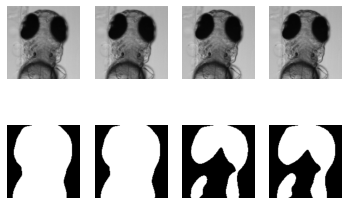

In [36]:
#  sanity check for the mask and images

startNum = 150
n_samples = 4

for i in range(n_samples):
    plt.subplot(2, n_samples, 1+i)
    plt.axis('off')
    plt.imshow(X_patches[int(i+startNum)], cmap='gray')
    
for i in range(n_samples):
    plt.subplot(2, n_samples, 1+n_samples+i)
    plt.axis('off')
    plt.imshow(Y_masks[int(i+startNum)], cmap='gray')    
plt.show()

## resize the data manually to avoid OOM

In [1]:
# data loading 

import os
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
import os
import pandas as pd
import random

In [2]:
# visualization for two images

def subShow(IMG1, IMG2):
    plt.figure()
    plt.subplot(1,2,1)
    plt.imshow(IMG1, cmap='gray')
    plt.subplot(1,2,2)
    plt.imshow(IMG2, cmap='gray')
    plt.show()

In [3]:
# 15 stacks of the images

PATH = '/bigdata/casus/MLID/RuiLi/Data/LM/zebrafish_partial_15/'

Mask = np.load(PATH + 'biMasks15.npy')
IMG = np.load(PATH + 'rawGray15.npy')

print(Mask.shape, IMG.shape)

(15, 20, 1040, 1392) (15, 20, 1040, 1392)


In [4]:
# [1040, 1392] -> [1040, 1040]

cropMask = Mask[:,:,:,176:(176+Mask.shape[2])]  # crop for later scaling
cropIMG = IMG[:,:,:,176:(176+IMG.shape[2])]

print('small Mask info: ', cropMask.shape, cropMask.dtype)
print('small Image info: ', cropIMG.shape, cropIMG.dtype)

small Mask info:  (15, 20, 1040, 1040) uint8
small Image info:  (15, 20, 1040, 1040) uint8


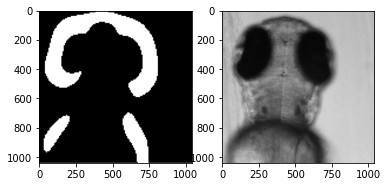

In [5]:
subShow(cropMask[0,1,:,:], cropIMG[0,1,:,:])

In [7]:
# resize the images

from skimage.transform import resize

Image = cropIMG
Mask = cropMask

SIZE = [256, 256]
totalIMG = Mask.shape[0]
# numIMG = 250
numIMG = totalIMG


smallIMG = resize(Image, (Image.shape[0],Image.shape[1],256, 256), anti_aliasing = False)
# smallIMG = np.interp(smallIMG, (smallIMG.min(), smallIMG.max()), (0, 1))  # rescale the img

smallMask = resize(Mask, (Mask.shape[0],Mask.shape[1],256, 256), anti_aliasing=False)
smallMask = smallMask.astype(int)
print('after resize:', smallIMG.shape, smallMask.shape)

after resize: (15, 20, 256, 256) (15, 20, 1040, 1392)


In [8]:
# save small dataset

PATH = '/bigdata/casus/MLID/RuiLi/Data/LM/zebrafish_partial_15/'

np.save(PATH + 'biMasks15_256.npy', smallMask)
np.save(PATH + 'rawGray15_256.npy', smallIMG)

# prepare stack images for whole stack seg

In [17]:
import imutils
import matplotlib.pyplot as plt

import os
import numpy as np
from scipy import ndimage
from tqdm import tqdm  # ! this might result into problem with 'object'
import pandas as pd
import random
import glob
from skimage import io

import argparse
import time
import cv2

In [2]:
def readTIF(data_list):
    images = []
    for img in range(len(data_list)):  # whole list
    # for img in glob.glob(os.path.join(data_path, "*.tif")):
        
        im = io.imread(data_list[img])  
        imarray = np.array(im)
        images.append(imarray)  # images, num of slices, channels, img.x, img.y
    return np.asarray(images)

## read in whole stacks and pick target stacks

In [ ]:
# check the file list

# list = []
# for file in sorted(os.listdir(ALL_PATH)):
#     if file.endswith(".tif"):
#         print(file)
#         list.append(file)
               

In [24]:
# whole stack path

ALL_PATH = '/bigdata/casus/MLID/zebrafish/all_toxo_mock/'
all_img_list = sorted(glob.glob(ALL_PATH + '/*.tif'))

print(len(all_img_list))

# last stacks for segmentation

numStack = 4
# stackList = all_img_list[-numStack :]
stackList = all_img_list[20:24]
# stackList = all_img_list[:4]  # series number for training is 170411
print(stackList)


80
['/bigdata/casus/MLID/zebrafish/all_toxo_mock/170411_6hpi_mock_33_MOCK_01.tif', '/bigdata/casus/MLID/zebrafish/all_toxo_mock/170411_6hpi_mock_33_MOCK_02.tif', '/bigdata/casus/MLID/zebrafish/all_toxo_mock/170411_6hpi_mock_33_MOCK_03.tif', '/bigdata/casus/MLID/zebrafish/all_toxo_mock/170411_6hpi_mock_33_MOCK_04.tif']


(4, 20, 1040, 1392)


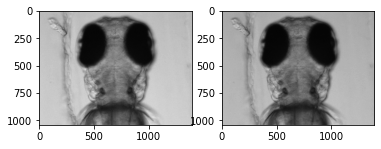

In [25]:
# read in and visualize

segStacks = readTIF(stackList)[:,:,1,...]  # take the gray channel out
print(segStacks.shape)

n_slice = 10
subShow(segStacks[0,n_slice,:,:,], segStacks[0,n_slice + 1,:,:,])

In [26]:
# segStacks[2,...].max()
print(segStacks.min(), segStacks.max())

0 113


## preprocess the stack. crop, resize and rescale

In [12]:
# rescale the gray stack

def rescaleStack(imageStack, MIN, MAX):

    ImageScale = []
    
    for stack in range(imageStack.shape[0]):
        temp = imageStack[stack,...]
        tempScale = np.interp(temp, (temp.min(), temp.max()), (MIN, MAX))
        # print(stack, tempScale.min(), tempScale.max())
        ImageScale.append(tempScale.astype('int'))
    
    return np.asarray(ImageScale)


In [13]:
from skimage.transform import resize


# crop
preSegStacks = segStacks[...,176:(176 + segStacks.shape[2])]  

# resize
preSegStacks = resize(preSegStacks, (preSegStacks.shape[0],preSegStacks.shape[1], 256, 256), anti_aliasing=False)

# rescale
preSegStacks = rescaleStack(preSegStacks, 0, 255)

print(preSegStacks.shape, preSegStacks.min(), preSegStacks.max())

(4, 20, 256, 256) 0 255


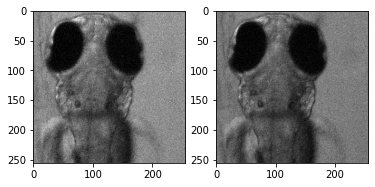

In [14]:
# visualize before and after

n_slice = 10

subShow(preSegStacks[0,n_slice,:,:,], preSegStacks[0,n_slice + 1,:,:,])

## save in target as npy. preprocessed

In [68]:
# save in path

# /bigdata/casus/MLID/RuiLi/Data/LM/segStacks
np.save('/bigdata/casus/MLID/RuiLi/Data/LM/segStacks/segStacks_170411_24.npy', preSegStacks)

# tensor to numpy

In [5]:
import tensorflow as tf

a = tf.constant([[1, 2], [3, 4]])                 
b = tf.add(a, 1)
# print(a)

c = tf.reduce_mean(a)
print(c)
d = c.numpy()
print(d)

tf.Tensor(2, shape=(), dtype=int32)
2


# gif generate in the hemera

In [18]:
from skimage import io

DATA_PATH = '/home/li52/code/LM/digitalConfocal/reports'

segPix = io.imread(DATA_PATH + '/UNet2D_vanilla/1_seg_result_deep.tif')
print(segPix.shape)

(20, 256, 256)


243.0 0.0


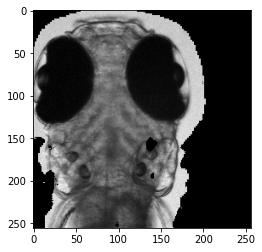

In [19]:
NUM = 19

plt.imshow(segPix[NUM,...], cmap='gray')

print(segPix.max(), segPix.min())

In [20]:
import numpy as np
from PIL import Image

# imgs = np.random.randint(0, 255, (100, 50, 50, 3), dtype=np.uint8)
imgs = segPix
imgs = [Image.fromarray(img) for img in imgs]
# duration is the number of milliseconds between frames; this is 40 frames per second
imgs[0].save("./test2.gif", save_all=True, append_images=imgs[1:], duration=200, loop=0)

# Manual GT for test dataset

In [25]:
def readTIF(data_list):
    images = []
    for img in range(len(data_list)):  # whole list
    # for img in glob.glob(os.path.join(data_path, "*.tif")):
        
        im = io.imread(data_list[img])  
        imarray = np.array(im)
        images.append(imarray)  # images, num of slices, channels, img.x, img.y
    return np.asarray(images)

(4, 20, 256, 256) 0 255


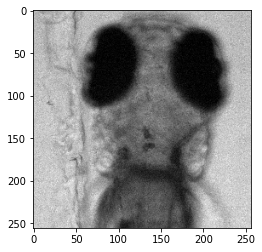

In [4]:
TEST_PATH = '/bigdata/casus/MLID/RuiLi/Data/LM/segStacks/segStacks_170411_24.npy'

test_dataset = np.load(TEST_PATH)
print(test_dataset.shape, test_dataset.min(), test_dataset.max())
# plt.imshow(test_dataset[0,0,...], cmap='gray')

uint8


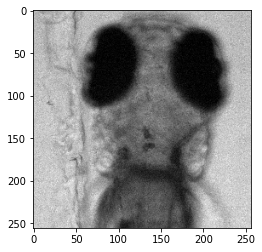

In [33]:
# 保存多张tif的stack

import numpy as np
from tifffile import imsave

# SAVE_PATH = '/bigdata/casus/MLID/RuiLi/Data/LM/segStacks/manualSeg/'
SAVE_PATH ='/home/li52/code/LM/digitalConfocal/data/zebra15/inputData/manualSeg/'

image = test_dataset[0,...].astype(np.uint8)
print(image.dtype)
# image = np.zeros((32, 256, 256), 'uint16')
plt.imshow(image[0,...], cmap='gray')
imsave(SAVE_PATH + 'testStack.tif', image)

In [27]:
ALL_PATH = '/bigdata/casus/MLID/RuiLi/Data/LM/segStacks/manualSeg/'
all_img_list = sorted(glob.glob(ALL_PATH + '/*.tiff'))
print(all_img_list)

['/bigdata/casus/MLID/RuiLi/Data/LM/segStacks/manualSeg/testStack.tiff']


In [24]:
test2 = readTIF(all_img_list)
print(test2.shape)


(1, 256, 256)
